### やること

- 対象データの決定
- 一定間隔でのデータに加工
- 欠損値の補完
- 部分空間法による変化点検知

In [3]:
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
import datetime
import math
import copy

from visualize import visualization as my_VS
from select_datasets import Select_datasets as my_SD

### データゲット

In [34]:
## cooler

place = "temp"
target_name_adr = ["CAMC_CT0","CAMC_CT1"]


path = f"/data7/2207_XRISM_PFT_TC7/db/{place}"
adr_pklfiles = glob.glob(path+"/**.pkl")

adr_pklfiles = sorted(adr_pklfiles)
index = adr_pklfiles.index('/data7/2207_XRISM_PFT_TC7/db/temp/temp_20220124-011840_20220124-040000.pkl')
adr_pklfiles = adr_pklfiles[index:]

In [35]:
List_adr_adrfile = []
List_time_adrfile = []

for d_adrfile in adr_pklfiles:
    with open(d_adrfile, 'rb') as adrf:
        d = pickle.load(adrf)
        if len(List_time_adrfile) != 0:
            List_adr_adrfile = List_adr_adrfile+list(d[target_name_adr].values)
            List_time_adrfile = List_time_adrfile+d.index.to_list()
        else:
            List_adr_adrfile = list(d[target_name_adr].values)
            List_time_adrfile = d.index.to_list()

In [36]:
# DataFrame 格納
df_adrfile = pd.DataFrame({
    "time":List_time_adrfile,
})

data_ = pd.DataFrame(List_adr_adrfile)
data_.columns = ["CAMC_CT0","adr"]

df_adrfile = pd.concat([df_adrfile,data_],axis=1)

In [37]:
List_time_adrfile = np.array(df_adrfile["time"])
List_adr_adrfile = np.array(df_adrfile["adr"])

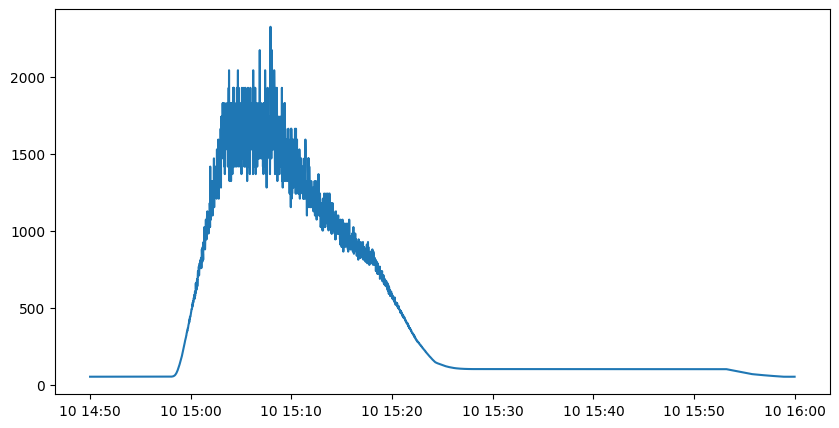

In [39]:
time_start = np.datetime64('2022-02-10T14:50:00.000000000')
time_stop = np.datetime64('2022-02-10T16:00:00.000000000')

index_range = ((List_time_adrfile > time_start) & (List_time_adrfile < time_stop))

List_time_adrfile_short = List_time_adrfile[index_range]
List_adr_adrfile_short = List_adr_adrfile[index_range]

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(List_time_adrfile_short,List_adr_adrfile_short)
#ax.set_ylim(-10,2000)

### データセットの前処理

In [40]:
df_adrfile_pre = copy.copy(df_adrfile)
df_adrfile_pre["time"]=df_adrfile["time"].dt.round("s")#秒で足切り
df_adrfile_pre = df_adrfile_pre.groupby(["time"]).aggregate(np.mean)#重複する秒の平均を取る
df_adrfile_pre = df_adrfile_pre.iloc[1:,:] #7/4を除く
df_adrfile_pre = df_adrfile_pre.resample("S").mean()#欠損値のindexを補完
df_adrfile_pre = df_adrfile_pre.fillna(method='ffill')#欠損値のadrを前の値で補完

df_adrfile_pre["adr"] = df_adrfile_pre.adr.rolling(10).mean()
df_adrfile_pre= df_adrfile_pre.iloc[10:,:]

In [41]:
List_time_adrfile_pre = df_adrfile_pre.index.to_numpy()
List_adr_adrfile_pre = np.array(df_adrfile_pre["adr"])

In [42]:
time_start = np.datetime64('2022-02-10T14:50:00.000000000')
time_stop = np.datetime64('2022-02-10T16:00:00.000000000')

index_range = ((List_time_adrfile_pre > time_start) & (List_time_adrfile_pre < time_stop))

List_time_adrfile_short = List_time_adrfile_pre[index_range]
List_adr_adrfile_short = List_adr_adrfile_pre[index_range]

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(List_time_adrfile_short,List_adr_adrfile_short)
#ax.set_ylim(-10,2000)

In [43]:
len(List_time_adrfile_short)

4199

### 微分

In [44]:
import sympy as sym

In [45]:
List_adr_adrfile_pre_diff = np.diff(List_adr_adrfile_pre)

In [47]:
time_start = np.datetime64('2022-02-10T14:50:00.000000000')
time_stop = np.datetime64('2022-02-10T16:00:00.000000000')

index_range = ((List_time_adrfile_pre > time_start) & (List_time_adrfile_pre < time_stop))


List_time_adrfile_short = List_time_adrfile_pre[index_range]
List_adr_adrfile_short = List_adr_adrfile_pre[index_range]
List_adr_adrfile_short_diff = List_adr_adrfile_pre_diff[index_range[1:]]

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(List_time_adrfile_short,List_adr_adrfile_short)
ax2 = ax.twinx()
ax2.plot(List_time_adrfile_short,List_adr_adrfile_short_diff,color="orange")
plt.savefig("result/diff_ADR.png")

### 加速度

In [53]:
List_adr_adrfile_pre_diff_diff = np.diff(List_adr_adrfile_pre_diff)

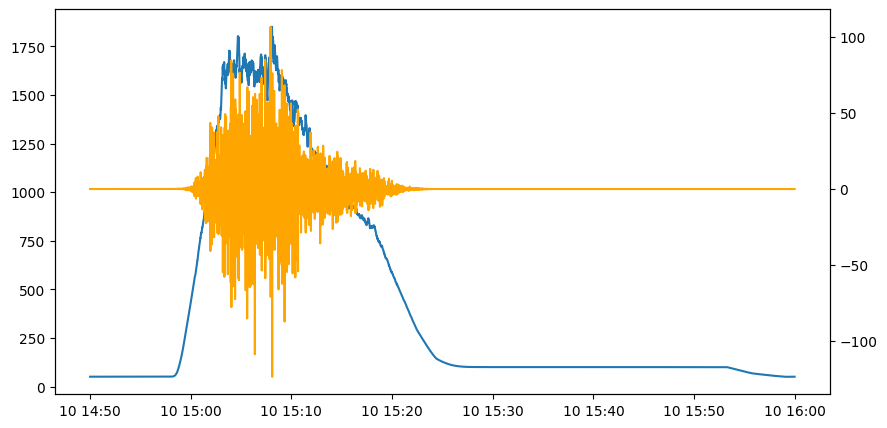

In [54]:
time_start = np.datetime64('2022-02-10T14:50:00.000000000')
time_stop = np.datetime64('2022-02-10T16:00:00.000000000')

index_range = ((List_time_adrfile_pre > time_start) & (List_time_adrfile_pre < time_stop))


List_time_adrfile_short = List_time_adrfile_pre[index_range]
List_adr_adrfile_short = List_adr_adrfile_pre[index_range]
List_adr_adrfile_short_diff_diff = List_adr_adrfile_pre_diff_diff[index_range[2:]]

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(List_time_adrfile_short,List_adr_adrfile_short)
ax2 = ax.twinx()
ax2.plot(List_time_adrfile_short,List_adr_adrfile_short_diff_diff,color="orange")

- 加速度だとうまく出ない

### change finder for normal

In [55]:
import changefinder

In [56]:
cf = changefinder.ChangeFinder(r=0.01,order=1,smooth=3)
result = np.empty(len(List_adr_adrfile_short))

for i,d in enumerate(List_adr_adrfile_short):
    a = cf.update(d)
    result[i] = cf.update(d)

In [57]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(List_time_adrfile_short,List_adr_adrfile_short,color="blue")
ax2 = ax.twinx()
ax2.plot(List_time_adrfile_short,result,color="red")

### changefinder for diff

In [18]:
cf = changefinder.ChangeFinder(r=0.001,order=1,smooth=3)
result_diff = np.empty(len(List_adr_adrfile_short_diff))

for i,d in enumerate(List_adr_adrfile_short_diff):
    a = cf.update(d)
    result_diff[i] = cf.update(d)

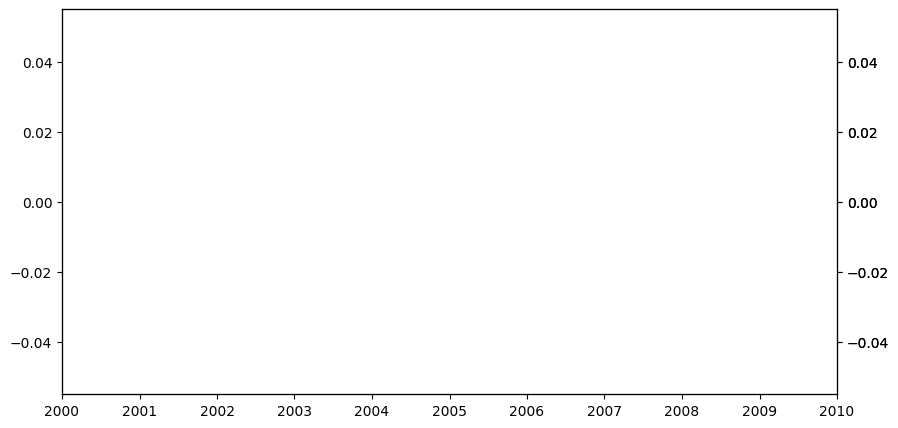

In [19]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(List_time_adrfile_short,List_adr_adrfile_short,color="blue")
ax2 = ax.twinx()
ax2.plot(List_time_adrfile_short,result_diff,color="red")
ax3 = ax.twinx()
ax3.plot(List_time_adrfile_short,List_adr_adrfile_short_diff,color="orange")

In [20]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(List_time_adrfile_short,List_adr_adrfile_short,color="blue")
ax2 = ax.twinx()
ax2.plot(List_time_adrfile_short,result_diff,color="red")

#### いい感じにできてるんじゃない？？

### 部分空間法

In [ ]:
class subspace_approach:
    
    def __init__(self,Data,window_range):
        self.Data = Data
        self.window_range = window_range
        
    def TrajetoryMatrix_X(self,first_start,final_start):
        
        return [self.Data[i:i+self.window_range] for i in range(first_start,final_start+1)]


In [ ]:
from sklearn.decomposition import TruncatedSVD
import scipy

result = []

traje_pattern_r = 5
test_pattern_m = 5
lag_L = 10
windw_M = 30
target_data = List_adr_adrfile_pre

for t in range(lag_L+2*windw_M,len(target_data)-windw_M):

    subspace = subspace_approach(target_data,windw_M)
    
    X_t = subspace.TrajetoryMatrix_X(t-windw_M-lag_L,t-windw_M)
    Z_t = subspace.TrajetoryMatrix_X(t-windw_M,t)

    U_t, S_diags, V_t = scipy.linalg.svd(X_t)
    U_r_t = U_t[:traje_pattern_r]

    Q_t, S_diags, V_t = scipy.linalg.svd(Z_t)
    Q_m_t = Q_t[:test_pattern_m]

    UQ = np.dot(U_r_t.T,Q_m_t)
    UQ_max = scipy.linalg.svd(UQ)[1][0]

    a_t = 1 - UQ_max

    result.append(a_t)
    
fig,ax = plt.subplots()

ax.plot(range(len(result)),result)
ax2 = ax.twinx()
ax2.plot(range(len(data)),data,color="red")

In [ ]:
fig,ax = plt.subplots()

ax.plot(List_time_adrfile_short[200:7000],result)
ax2 = ax.twinx()
ax2.plot(List_time_adrfile_short[200:7000],List_adr_adrfile_short[200:7000],color="red")

### 部分空間法　another ver

In [77]:
noise = np.random.randint(1, 1000, np.shape(List_adr_adrfile_short))/1000

List_adr_adrfile_pre_bubun = List_adr_adrfile_short + noise

In [78]:
class subspace_approach:
    
    def __init__(self,Data,window_range):

        self.Data = np.array(Data)
        self.window_range = window_range
        
    def TrajetoryMatrix_X(self,first_start,final_start):
        
        return np.array([self.Data[i:i+self.window_range] for i in range(first_start,final_start+1)])
    
    
def gyaku_sqrt(X):
    if np.linalg.det(X) == 0:
        return X
    return scipy.linalg.sqrtm(np.linalg.inv(X))


In [84]:
from sklearn.decomposition import TruncatedSVD
import scipy

result = []

# データのとり方パラメータ
# traje_pattern_r = 5
# test_pattern_m = 5
# lag_L = 45
# windw_M = 30

traje_pattern_r = 10
lag_L = 50
windw_M = 50


# 対象データ
target_data = List_adr_adrfile_short

for t in range(lag_L+3*windw_M,len(target_data)-2*windw_M):

    subspace = subspace_approach(target_data,windw_M)
    
    ########## Yp Yf Z の設定
    
    Yp_t = subspace.TrajetoryMatrix_X(t-3*windw_M-lag_L,t-2*windw_M)
    Yf_t = subspace.TrajetoryMatrix_X(t-2*windw_M-lag_L,t-windw_M)
    Z_t = subspace.TrajetoryMatrix_X(t,t+windw_M)
    
    ######### Yp Yfから共分散を導出
    
    Sigmapp = 1/(windw_M-1)* np.dot(Yp_t.T,Yp_t)
    Sigmafp = 1/(windw_M-1)* np.dot(Yf_t.T,Yp_t)
    Sigmaff = 1/(windw_M-1)* np.dot(Yf_t.T,Yf_t)
    
    ######### 共分散から U_1 S_1　を導出
    
    o_t = np.dot(gyaku_sqrt(Sigmaff).T,Sigmafp)
    o_t = np.dot(o_t,gyaku_sqrt(Sigmapp))

    U_t, S_diags, V_t = scipy.linalg.svd(o_t)
    U_r_t = U_t[:traje_pattern_r]
    S_r_t = np.diag(S_diags[:traje_pattern_r])
    
    #########  U_1 S_1 から O　をどうにゅつ
    
    O_t = np.dot(scipy.linalg.sqrtm(Sigmaff).T,U_r_t.T)
    O_t = np.dot(O_t,scipy.linalg.sqrtm(S_r_t).T)
    
    ######### Oの特異値分解から Uを導出
    
    U,S,V = scipy.linalg.svd(O_t)
    
    ########### Dの導出
    
    D = sum([np.dot(z,z.T)-np.dot(np.dot(z,U.T),np.dot(U,z.T)) for z in Z_t])
    
    ########### Dの正規化
    D_NomralizeConst = sum([np.dot(y,y.T)-np.dot(np.dot(y,U.T),np.dot(U,y.T))for y in Yf_t])
    D_normalize = D/D_NomralizeConst
    
    ########### 結果の保存
    
    result.append(D_normalize)

######### 表示

    
fig,ax = plt.subplots()

ax.plot(range(lag_L+3*windw_M,len(target_data)-2*windw_M),result)
ax2 = ax.twinx()
ax2.plot(range(len(data)),data,color="red")


/usr/local/conda/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/conda/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/conda/lib/python3.7/site-packages/scipy/linalg/decomp_schur.py:283: RuntimeWarning: divide by zero encountered in cdouble_scalars
  c = mu[0] / r
/usr/local/conda/lib/python3.7/site-packages/scipy/linalg/decomp_schur.py:284: RuntimeWarning: divide by zero encountered in cdouble_scalars
  s = T[m, m-1] / r
/usr/local/conda/lib/python3.7/site-packages/scipy/linalg/decomp_schur.py:284: RuntimeWarning: invalid value encountered in cdouble_scalars
  s = T[m, m-1] / r


ValueError: array must not contain infs or NaNs

/usr/local/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


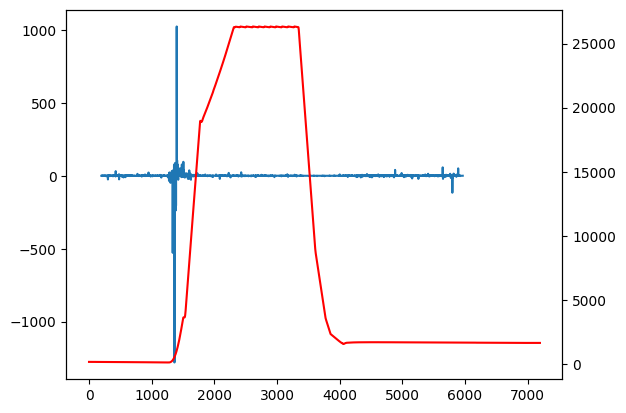

In [85]:
fig,ax = plt.subplots()

ax.plot(range(lag_L+3*windw_M,len(result)+lag_L+3*windw_M),result)
ax2 = ax.twinx()
ax2.plot(range(len(List_adr_adrfile_pre_bubun)),List_adr_adrfile_pre_bubun,color="red")

部分空間法できないわ....